In [10]:
# imports
import string
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import matplotlib.cm as cm
from scipy.spatial import cKDTree

import sys
sys.path.append("..")
import common

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [11]:
# stolen from notebook9
filename = "glove.6B.50d.txt"

embeddings = {}
with open(filename,'r', encoding='utf-8') as file:
    for line in file:
        elements = line.split();
        word = elements[0];
        vector = np.asarray(elements[1:],"float32")
        embeddings[word] = vector

In [20]:
# functions
def mean_emb(text):
    """
    Parameters:
    text (string): raw text from data
    
    Returns:
    numpy.ndarray(50,): mean embedding of text
    """
    pre = text.split()
    sum_emb = np.zeros(50,)
    for word in pre:
        if word in embeddings:
            sum_emb += embeddings[word]
    mean_emb = sum_emb/50
    
    return mean_emb

def glove_accuracy(X_train, X_test, y_train, y_test):
    train_embeddings = np.array([mean_emb(text) for text in X_train])
    test_embeddings = np.array([mean_emb(text) for text in X_test])

    clf = GaussianNB().fit(train_embeddings, y_train)

    predictions = clf.predict(test_embeddings)
    accuracy = accuracy_score(y_test, predictions)

    return round(accuracy,ndigits=3)

In [21]:
## Spam data

In [22]:
spam_train, spam_test = common.load_data('spam')
glove_accuracy(spam_train['texts'], spam_test['texts'], spam_train['labels'], spam_test['labels'])

0.934

In [15]:
news_train, news_test = common.load_data('news')
glove_accuracy(news_train['texts'], news_test['texts'], news_train['labels'], news_test['labels'])

0.84

## PCA

## sms

In [16]:
def pca(X_train):
    vectors = np.zeros((50, len(X_train)))
    for i in range(len(X_train)):
        doc = X_train[i]
        vectors[:,i] = mean_emb(doc)
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    #compute the covariance matrix
    S = np.cov(data)
    #obtain eigenvectors and eigenvalues
    eigenValues, eigenVectors = eigh(S)
    #sort according to size of eigenvalues
    sort_idx = np.argsort(eigenValues)[::-1]
    eigenValues = eigenValues[sort_idx]
    eigenVectors = eigenVectors[:, sort_idx]
    return eigenValues, eigenVectors, data

In [17]:
def plot_pca(X_train, y_train, PC_range, num_texts):
    eigenValues, eigenVectors, data = pca(X_train)
    X_proj = eigenVectors[:,PC_range[0]:PC_range[1]].T@data    
    #plot for the selected two principal components
    n_label = len(np.unique(y_train))
    colors = cm.rainbow(np.linspace(0, 1, n_label))
    class_idx = y_train
    if n_label == 2:
        considered_classes = ['not-spam','spam']
    else:
        considered_classes = ['World','sports','Business', 'Sci/Tec']
    cdict = {i: colors[i] for i in range(n_label)}
    label_dict = {i: considered_classes[i] for i in range(n_label)}
    for i in range(n_label):
        indices = np.where(class_idx == i)
        plt.scatter(X_proj[0,indices], X_proj[1,indices],
                 color=cdict[i], label=label_dict[i],s=2)
    plt.legend(loc='best')
    plt.xlabel('Principal Component axis 1');
    plt.ylabel('Principal Component axis 2');
    plt.show()

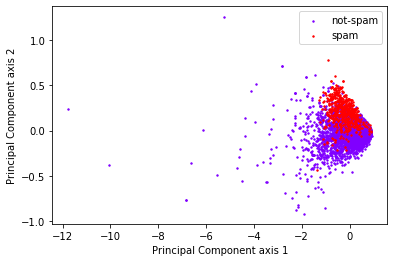

In [116]:
plot_pca(spam_train['texts'], spam_train['labels'], [0,2], None)

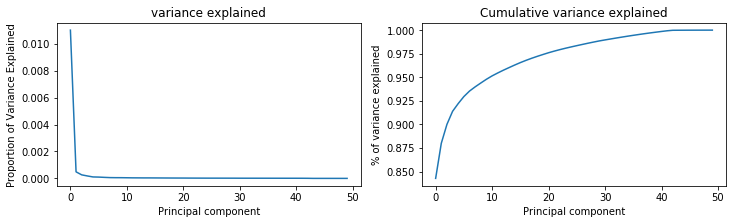

In [21]:
# explained variance
# week5 NB
eigenValues, eigenVectors, _ = pca(spam_train['texts'])

summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(50)
relative_var = np.zeros(50)
for i in range(50):    
    relative_var[i] = eigenValues[i]/np.size(eigenValues)
    cumsum += eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
# this might not be calculated correctly (line 10)
plt.plot(relative_var)
plt.xlabel("Principal component")
plt.ylabel("Proportion of Variance Explained")
plt.title('variance explained');
plt.subplot(122) 
plt.plot(total_var_explained)
plt.xlabel("Principal component")
plt.ylabel("% of variance explained")
plt.title('Cumulative variance explained');

Maybe add a vertical line at x=2

In [22]:
total_var_explained[0:2]

array([0.84271529, 0.87993501])

### News

Currently it just shows the first 5000 articles, we could maybe change it to be 5000 random. np.random.choice()

Or we could just say that the first 5k are representative of the population

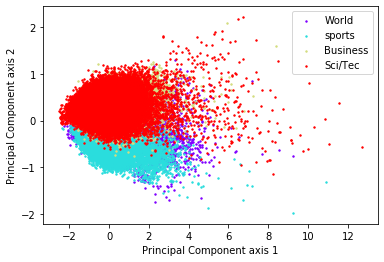

In [18]:
plot_pca(news_train['texts'], news_train['labels'], [0,2], 5000)

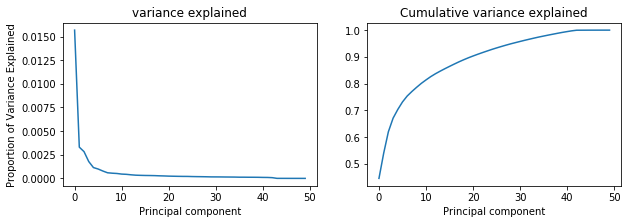

In [23]:
# explained variance
eigenValues, eigenVectors, _ = pca(news_train['texts'])

summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(50)
relative_var = np.zeros(50)
for i in range(50):    
    relative_var[i] = eigenValues[i]/np.size(eigenValues)
    cumsum += eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig = plt.figure(figsize=(10,3))
plt.subplot(121)    
plt.plot(relative_var)
plt.xlabel("Principal component")
plt.ylabel("Proportion of Variance Explained")
plt.title('variance explained');
plt.subplot(122) 
plt.plot(total_var_explained)
plt.xlabel("Principal component")
plt.title('Cumulative variance explained');

In [27]:
#ideally we would need 10 components to explain 80% variance
total_var_explained[0:10]

array([0.44570034, 0.53958729, 0.62004716, 0.67078518, 0.70334049,
       0.73153279, 0.75368876, 0.77059866, 0.78621263, 0.80096919])

## Similar news

In [7]:
new_news = common.load_similar_news("../similar_news.txt")

In [217]:
all_news = {'texts': np.append(news_train['texts'],new_news['texts']),'labels': np.append(news_train['labels'],new_news['labels'])}
all_news['texts'][-14:]

array(['The rise of self-driving taxis in China comes at a time when people are nervous about taking public transport.',
       'A woman who accuses Democratic White House candidate Joe Biden of sexually assaulting her 27 years ago has called on him to quit the presidential race.',
       'Germany\'s parliament has passed a law banning so-called "gay conversion therapy" for young people nationwide.',
       "The UK's most modern nuclear power station could be partially powered down as the National Grid looks to manage lower energy demands.",
       "World Athletics says Nike's controversial Vaporfly range will not be banned but there will be tighter regulations around high-tech running shoes.",
       'Formula 1 chairman Chase Carey has admitted that the sport\'s owners are preparing for "the remote possibility of no racing in 2020".',
       "Anthony Joshua's next bout could take place in a Roman amphitheatre in Croatia, says the manager of mandatory challenger Kubrat Pulev.",
       

In [238]:
eigenValues, eigenVectors, data = pca(all_news['texts'])

In [243]:
X_proj = eigenVectors[:,0:2].T@data
X_proj.shape

(2, 120014)

In [241]:
def plot_pca(X_train, y_train, PC_range, num_texts, examples):
    global eigenValues, eigenVectors, data
    #plot for the selected two principal components
    X_proj = eigenVectors[:,PC_range[0]:PC_range[1]].T@data    
    n_label = len(np.unique(y_train))
 
    if n_label == 2:
        considered_classes = ['Not-spam','Spam']
    else:
        considered_classes = ['World','Sports', 'Business', 'Sci/Tec']
        
    colors = cm.rainbow(np.linspace(0, 1, n_label))
    cdict = {i: colors[i] for i in range(n_label)}
    label_dict = {i: considered_classes[i] for i in range(n_label)}
    
    f = plt.figure(figsize=(10,7))
    class_idx = y_train[:num_texts]
    for i in range(n_label):
        indices = np.where(class_idx == i)
        plt.scatter(X_proj[0,indices], X_proj[1,indices],
                 color=cdict[i], label=label_dict[i],s=5)
    if examples:
        class_idx = y_train[-14:]
        for i in range(n_label):
            indices = np.where(class_idx == i)
            if i == 0:
                marker = 'v'
            elif i == 1:
                marker = '^'
            elif i == 2:
                marker = '.'
            elif i == 3:
                marker = 'o'
            plt.scatter(X_proj[0,indices], X_proj[1,indices],
                        label=label_dict[i],s=60, color='black', marker=marker)
    plt.legend(loc='best')
    plt.xlabel('Principal Component axis 1');
    plt.ylabel('Principal Component axis 2');
    plt.show()

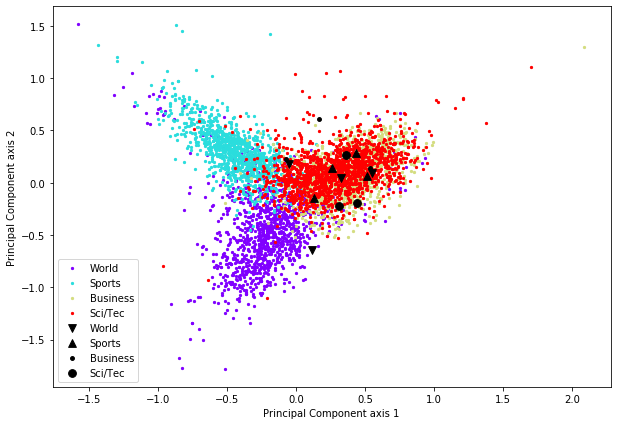

In [254]:
plot_pca(all_news['texts'], all_news['labels'], [1,3], 2000, True)

### Getting coordinates from PCA plot

In [255]:
def get_coords(X_train, y_train, PC_range, queries):
    global eigenValues, eigenVectors, data
    X_proj = eigenVectors[:,PC_range[0]:PC_range[1]].T@data  
    n_label = len(np.unique(y_train))
    considered_classes = ['World', 'Sports', 'Business', 'Sci/Tec']
        
    label_dict = {i: considered_classes[i] for i in range(n_label)}
    class_idx = y_train
    x_new = np.array([])
    y_new = np.array([])
    x = X_proj[0,:]
    y = X_proj[1,:]
    x_new = np.append(x_new,x)
    y_new = np.append(y_new,y)
    
    if queries < 0:
        coordmat = np.zeros((abs(queries),2))
        coordmat[:abs(queries),0] = x_new[queries:]
        coordmat[:abs(queries),1] = y_new[queries:]
    else:
        coordmat = np.zeros((queries,2))
        coordmat[:queries,0] = x_new[:queries]
        coordmat[:queries,1] = y_new[:queries]  
           
    return coordmat
coordmat = get_coords(all_news['texts'], all_news['labels'], [1,3], 12000)
queries = get_coords(all_news['texts'], all_news['labels'], [1,3], -14)

print(queries.shape)
print(coordmat.shape)

(14, 2)
(12000, 2)


In [256]:
def nearest_neighbor(coordmat, queries,k):
    Tree = cKDTree(coordmat, leafsize=100)
    
    dist, idx = Tree.query(queries,k=k)
    originalid = idx
    # note when we are doing this, we are assuming that the order is preserved
    nearest_neighbor = all_news['texts'][idx]
    
    return nearest_neighbor, originalid

nearest_neighbors, originalid = nearest_neighbor(coordmat, queries,3)

In [258]:
#sanity check that the returned article is indeed close
print(originalid)
print(queries[0,:])
print(coordmat[originalid[0,0],:])

[[ 1393   930  1057]
 [ 5222  7579  2257]
 [ 4100 11758  1156]
 [10206  5630  5333]
 [ 1318 11660  9208]
 [ 6127  3515  4689]
 [ 4482  1412  5996]
 [ 8973   401 11884]
 [11212  7842  3301]
 [11487  2863    44]
 [ 5446  5621  6539]
 [ 8711  1627 11227]
 [10859  2863  9478]
 [ 9159  7488  9272]]
[ 0.035727   -0.07267638]
[ 0.03110009 -0.07629373]


## Comparing articles

In [261]:
#labels are ['World','Sports', 'Business', 'Sci/Tec']
for i in range(14):
    print("Article(s) in corpus","\n")
    print("label:", all_news['labels'][originalid[i]],",","text:", nearest_neighbors[i],"\n")
    print("Compared article","\n")
    print("label:", all_news['labels'][-14+i],",","text:", all_news['texts'][-14+i],"\n","\n")

Article(s) in corpus 

label: [0 3 3] , text: ['790 , 000 still have no power in florida punta gorda , fla . - about 790 , 000 people remain without power in florida in the aftermath of hurricane charley , and officials estimate it could take weeks to get electricity fully restored . . .'
 'kan . to move forward on dinosaur exhibit ( ap ) ap - concerns about funding and poor attendance will not stop plans to bring a dinosaur exhibit to science city at union station , university of kansas and science city officials said .'
 'scientists work on cure for mysterious nerve disease by lauran neergaard washington ( ap ) -- dr . douglas kerr painstakingly collected spinal fluid from hundreds of patients with a mysterious disease that can paralyze within hours of attacking - and thinks he may have found a way to fight back . . .'] 

Compared article 

label: 0 , text: The rise of self-driving taxis in China comes at a time when people are nervous about taking public transport. 
 

Article(s) in

This should be compared to this list

- 0,3/2 https://www.bbc.com/news/business-52392366
- 0 https://www.bbc.com/news/world-us-canada-52584774 
- 0 https://www.bbc.com/news/world-europe-52585162
- 0, 3 https://www.bbc.com/news/uk-england-suffolk-52566082
- 1, 3 https://www.bbc.com/sport/av/athletics/51332721 
- 1 https://www.bbc.com/sport/formula1/52568642
- 1 https://www.bbc.com/sport/boxing/52573766
- 2 https://www.bbc.com/news/business-52570600
- 2 https://www.bbc.com/news/business-52580950 
- 2, 3 https://www.bbc.com/news/business-52570714 
- 3 https://www.bbc.com/news/science-environment-52550973 
- 3 https://www.bbc.com/news/technology-52572381
- 3 https://www.bbc.com/news/science-environment-52560812 

In some cases it is actually pretty accurate. Like this article

Facebook and Google have said they will let employees continue working from home for the rest of the year. The tech giants have announced plans to reopen their offices soon but are allowing more home working flexibility.

We originally labeled it as 2, but it could quite easily be a 3, since Facebook and google are tech companies. Although the articles in the corpus are not similiar category they often have really similar content. In some cases only the class is the same though.